In [220]:
# Import libraries
import pandas as pd
import numpy as np

In [188]:
# Read the csv file into a Dataframe object
df = pd.read_csv('../homework-03/bank-full.csv', delimiter=';')

In [189]:
# Show the firts rows
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [190]:
# Select a subset of features from the dataset
columns = ['age','job','marital','education','balance','housing','contact','day','month','duration','campaign','pdays','previous','poutcome','y']
df = df[columns]

# Encode target column
df['y'] = (df['y'] == 'yes').astype(int)

# Show the result dataframe
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [192]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1
from sklearn.model_selection import train_test_split

In [193]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [194]:
y_train = df_train.y.values
y_val = df_val.y.values
del df_train['y']
del df_val['y']

In [195]:
# Check the shape of result dataframes
(df_train.shape, y_train.shape), (df_val.shape, y_val.shape)

(((27126, 14), (27126,)), ((9042, 14), (9042,)))

In [152]:
# Another way to do the last split
X_train2, X_val2, y_train2, y_val2 = train_test_split(df_train_full.drop('y', axis=1), df_train_full.y, test_size=0.25, random_state=1)
(X_train2.shape, y_train2.shape), (X_val2.shape, y_val2.shape)

(((27126, 14), (27126,)), ((9042, 14), (9042,)))

In [196]:
# Select numerical and categorical columns
numerical = df_train.columns[df_train.dtypes == 'int64'].tolist()
categorical = df_train.columns[df_train.dtypes == 'object'].tolist()

### ROC AUC for feature selection

In [197]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [213]:
# Calculate ROC AUC score for each numerical feature
scores = []

for col in numerical:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        # Invert if AUC < 0.5
        auc = roc_auc_score(y_train, -df_train[col])
    scores.append((col, auc))

df_scores = pd.DataFrame(scores, columns=['feature', 'roc_auc_score'])
df_scores.sort_values(by='roc_auc_score', ascending=False, inplace=True)
df_scores.set_index('feature', inplace=True)

df_scores

,roc_auc_score
feature,
duration,0.814700
previous,0.598565
pdays,0.590128
balance,0.588831
campaign,0.571454
day,0.525958
age,0.512186


Text(0, 0.5, 'roc-auc')

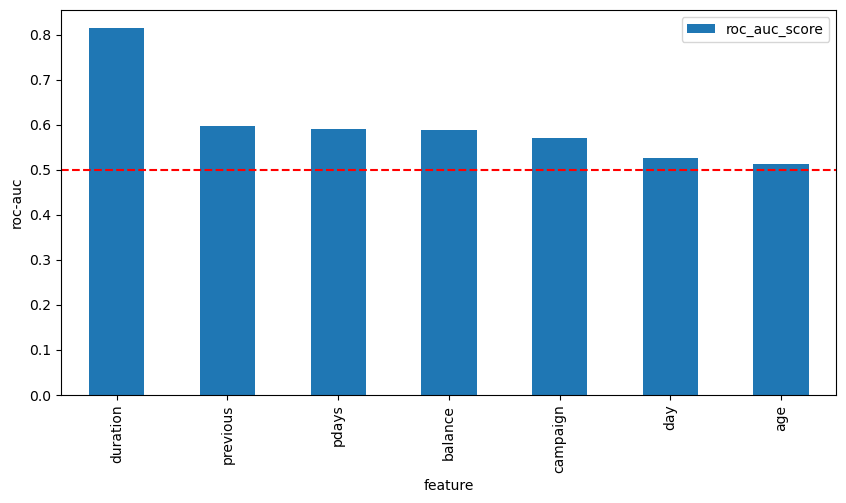

In [214]:
df_scores.plot.bar(figsize=(10,5))
plt.axhline(y=0.5, color='r', linestyle='--', label='y=0.5')
plt.ylabel('roc-auc')

### Model training

In [215]:
from sklearn.feature_extraction import DictVectorizer

In [216]:
dicts_train = df_train.to_dict(orient='records')
dicts_val = df_val.to_dict(orient='records')
dv = DictVectorizer()

X_train = dv.fit_transform(dicts_train)
X_val = dv.transform(dicts_val)


In [227]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)
score = roc_auc_score(y_val, y_pred[:,1])

print('roc_auc_score = %0.3f' % score)

roc_auc_score = 0.900


### Precision and recall

In [243]:
# Dataframe of scores

scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    tp = ((y_pred[:,1] >= t) & (y_val == 1)).sum()
    fp = ((y_pred[:,1] >= t) & (y_val == 0)).sum()
    fn = ((y_pred[:,1] < t) & (y_val == 1)).sum()
    tn = ((y_pred[:,1] < t) & (y_val == 0)).sum()
    
    scores.append((t, tp, fp, fn, tn))
    
df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,1098,7944,0,0,0.121433,1.000000
1,0.01,1094,6958,4,986,0.135867,0.996357
2,0.02,1093,5764,5,2180,0.159399,0.995446
3,0.03,1086,4733,12,3211,0.186630,0.989071
4,0.04,1067,3776,31,4168,0.220318,0.971767
...,...,...,...,...,...,...,...
96,0.96,32,17,1066,7927,0.653061,0.029144
97,0.97,25,15,1073,7929,0.625000,0.022769
98,0.98,22,10,1076,7934,0.687500,0.020036
99,0.99,10,6,1088,7938,0.625000,0.009107


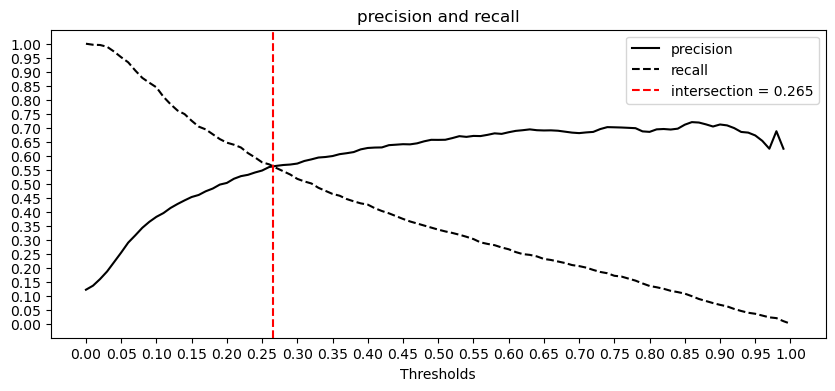

In [264]:
# Plot precision & recall vs thresholds
plt.figure(figsize=(10, 4))

plt.plot(df_scores.threshold, df_scores.precision, color='black', linestyle='solid', label='precision')
plt.plot(df_scores.threshold, df_scores.recall, color='black', linestyle='dashed', label='recall')
plt.axvline(x=0.265, color='r', linestyle='--', label='intersection = 0.265')
plt.legend()

plt.xticks(np.linspace(0, 1, 21))
plt.yticks(np.linspace(0, 1, 21))

plt.xlabel('Thresholds')
plt.title('precision and recall')

plt.show()

In [246]:
# Add F1 score to the scores dataframe
df_scores['f1'] = 2 * (df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall)
df_scores

,threshold,tp,fp,fn,tn,precision,recall,f1
0,0.00,1098,7944,0,0,0.121433,1.000000,0.216568
1,0.01,1094,6958,4,986,0.135867,0.996357,0.239126
2,0.02,1093,5764,5,2180,0.159399,0.995446,0.274796
3,0.03,1086,4733,12,3211,0.186630,0.989071,0.314009
4,0.04,1067,3776,31,4168,0.220318,0.971767,0.359199
...,...,...,...,...,...,...,...,...
96,0.96,32,17,1066,7927,0.653061,0.029144,0.055798
97,0.97,25,15,1073,7929,0.625000,0.022769,0.043937
98,0.98,22,10,1076,7934,0.687500,0.020036,0.038938
99,0.99,10,6,1088,7938,0.625000,0.009107,0.017953


In [280]:
# Max F1 score
max_row = df_scores.loc[df_scores['f1'].idxmax()]
print(max_row)

threshold       0.220000
tp            691.000000
fp            620.000000
fn            407.000000
tn           7324.000000
precision       0.527079
recall          0.629326
f1              0.573682
Name: 22, dtype: float64


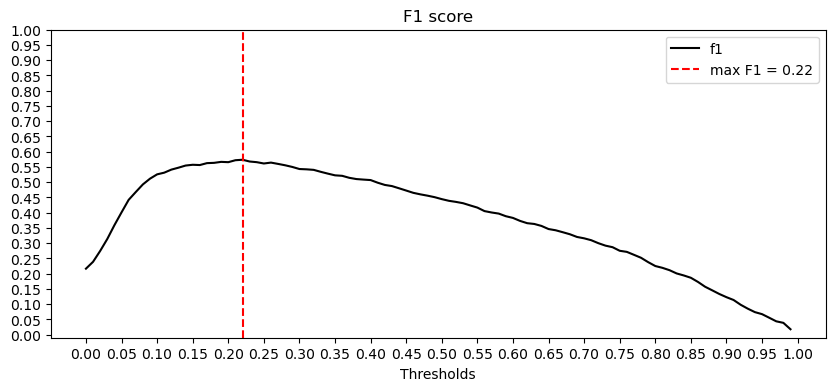

In [263]:
# Plot F1 scores vs thresholds
plt.figure(figsize=(10, 4))

plt.plot(df_scores.threshold, df_scores.f1, color='black', linestyle='solid', label='f1')
plt.axvline(x=0.22, color='r', linestyle='--', label='max F1 = 0.22')
plt.legend()

plt.xticks(np.linspace(0, 1, 21))
plt.yticks(np.linspace(0, 1, 21))

plt.xlabel('Thresholds')
plt.title('F1 score')

plt.show()

### K-fold cross-validation

In [267]:
def train(df, y):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(dicts)

    X = dv.transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


In [268]:
from sklearn.model_selection import KFold

In [270]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [271]:
aucs = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.y.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.y.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [272]:
# score array
np.array(aucs).round(3)

array([0.9  , 0.899, 0.911, 0.908, 0.912])

In [279]:
# Mean and std deviation of scores
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.906 ± 0.006


### Parameter tuning

In [278]:
def train(df, y, C=1.0):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(dicts)

    X = dv.transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)

    return dv, model

In [277]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=1e-06, auc = 0.701 ± 0.009
C=0.001, auc = 0.861 ± 0.007
C=1, auc = 0.906 ± 0.006
